
# Few-Shot Classification with MAML  
**Moving Circle Dataset**  

This notebook implements:
1. Dataset generation  
2. MAML (Model-Agnostic Meta-Learning)  
3. Baseline (joint training + fine-tuning)  
4. Quantitative evaluation  
5. Qualitative decision boundary visualizatio


In [10]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)




## Dataset: Moving Circle Task
Each task corresponds to a circle of fixed radius but random center.


In [9]:
def sample_circle_task(n_samples, r=2.0):
    cx, cy = np.random.uniform(-3, 3, size=2)
    X = np.random.uniform(-5, 5, size=(n_samples, 2))
    y = ((X[:, 0] - cx)**2 + (X[:, 1] - cy)**2 < r**2).astype(np.float32)
    return (
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.float32),
        (cx, cy)
    )




## Model Definition
Simple MLP classifier.


In [26]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze()




In [27]:
def clone_model(model):
    clone = MLP().to(device)
    clone.load_state_dict(model.state_dict())
    return clone



## Part 1: MAML Implementation


In [40]:
def train_maml(model, epochs=2000, tasks_per_batch=16,
               inner_lr=0.01, meta_lr=1e-3):

    meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        meta_optimizer.zero_grad()
        meta_loss = 0.0

        for _ in range(tasks_per_batch):
            X, y, _ = sample_circle_task(50)
            X, y = X.to(device), y.to(device)

            support_X, support_y = X[:10], y[:10]
            query_X, query_y = X[10:], y[10:]

            # Forward on support
            preds = model(support_X)
            loss = loss_fn(preds, support_y)

            # Compute gradients w.r.t. model parameters
            grads = torch.autograd.grad(
                loss,
                model.parameters(),
                create_graph=True
            )

            # Manual inner update (DIFFERENTIABLE)
            fast_weights = [
                param - inner_lr * grad
                for param, grad in zip(model.parameters(), grads)
            ]

            # Forward on query using fast weights
            def forward_fast(x, weights):
                idx = 0
                for layer in model.net:
                    if isinstance(layer, nn.Linear):
                        x = torch.nn.functional.linear(
                            x,
                            weights[idx],
                            weights[idx + 1]
                        )
                        idx += 2
                    else:
                        x = layer(x)
                return x.squeeze()

            query_preds = forward_fast(query_X, fast_weights)
            task_loss = loss_fn(query_preds, query_y)
            meta_loss += task_loss

        meta_loss /= tasks_per_batch
        meta_loss.backward()
        meta_optimizer.step()

        if epoch % 200 == 0:
            print(f"MAML Epoch {epoch}, Meta Loss: {meta_loss.item():.4f}")




## Part 2: Baseline (Joint Training)


In [41]:
def sample_many_tasks(tasks=50,samples_per_task=5
):
    X_all, y_all = [], []

    for _ in range(tasks):
        X, y, _ = sample_circle_task(samples_per_task)
        X_all.append(X)
        y_all.append(y)

    return torch.cat(X_all), torch.cat(y_all)



In [42]:
def train_baseline(model, epochs=2000, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        X, y = sample_many_tasks()
        X, y = X.to(device), y.to(device)

        loss = loss_fn(model(X), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Baseline Epoch {epoch}, Loss: {loss.item():.4f}")



## Training Both Models


In [43]:
maml_model = MLP().to(device)
baseline_model = MLP().to(device)

train_maml(maml_model)
train_baseline(baseline_model)


MAML Epoch 0, Meta Loss: 0.6604
MAML Epoch 200, Meta Loss: 0.3274
MAML Epoch 400, Meta Loss: 0.3074
MAML Epoch 600, Meta Loss: 0.3641
MAML Epoch 800, Meta Loss: 0.3585
MAML Epoch 1000, Meta Loss: 0.3301
MAML Epoch 1200, Meta Loss: 0.2928
MAML Epoch 1400, Meta Loss: 0.3158
MAML Epoch 1600, Meta Loss: 0.3011
MAML Epoch 1800, Meta Loss: 0.2759
Baseline Epoch 0, Loss: 0.5996
Baseline Epoch 200, Loss: 0.3467
Baseline Epoch 400, Loss: 0.2992
Baseline Epoch 600, Loss: 0.3100
Baseline Epoch 800, Loss: 0.3447
Baseline Epoch 1000, Loss: 0.3612
Baseline Epoch 1200, Loss: 0.2887
Baseline Epoch 1400, Loss: 0.2845
Baseline Epoch 1600, Loss: 0.2966
Baseline Epoch 1800, Loss: 0.2769



## Quantitative Evaluation



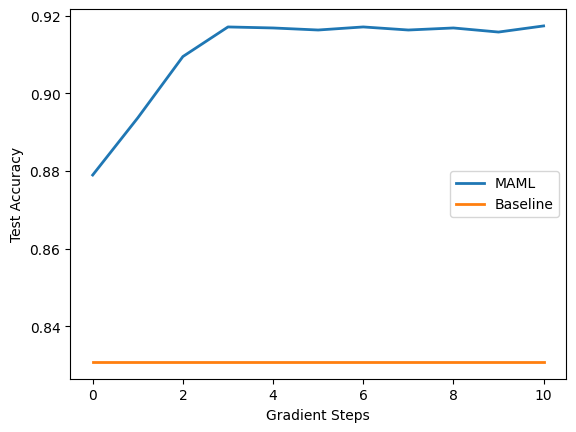

In [47]:
def evaluate_many_tasks(model, n_tasks=20, steps=10):
    accs = np.zeros(steps + 1)

    for _ in range(n_tasks):
        X, y, _ = sample_circle_task(
            200,
            r=np.random.uniform(0.5, 3.5)  # stronger shift
        )
        X, y = X.to(device), y.to(device)
        accs += np.array(evaluate_adaptation(model, X, y, steps))

    return accs / n_tasks
maml_acc = evaluate_many_tasks(maml_model)
baseline_acc = evaluate_many_tasks(baseline_model)

plt.plot(maml_acc, label="MAML", linewidth=2)
plt.plot(baseline_acc, label="Baseline", linewidth=2)
plt.xlabel("Gradient Steps")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()





## Qualitative Visualization
Decision boundary comparison after 1 gradient step.


In [33]:
def plot_boundary(model, title):
    xx, yy = np.meshgrid(np.linspace(-5, 5, 200),
                         np.linspace(-5, 5, 200))
    grid = torch.tensor(
        np.c_[xx.ravel(), yy.ravel()],
        dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        zz = model(grid).cpu().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, zz, levels=50, cmap="coolwarm")
    plt.colorbar()
    plt.title(title)
    plt.show()



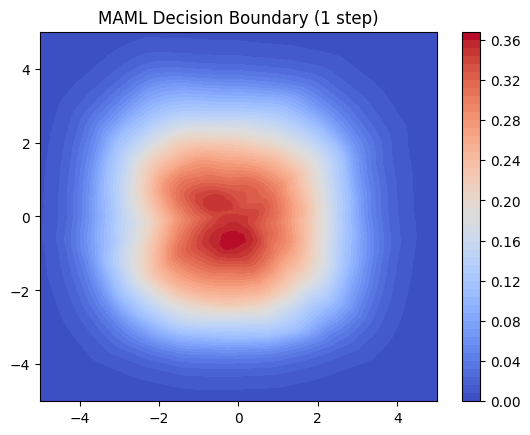

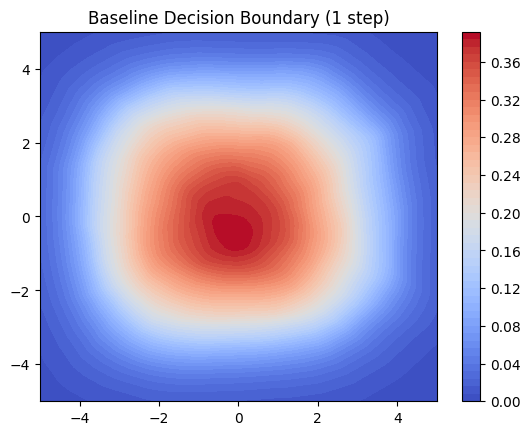

In [48]:
def adapt_one_step(model, support_X, support_y, lr=0.01):
    temp = clone_model(model)
    optimizer = optim.SGD(temp.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    loss = loss_fn(temp(support_X), support_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return temp
support_X, support_y = X_test[:10], y_test[:10]

maml_adapted = adapt_one_step(maml_model, support_X, support_y)
baseline_adapted = adapt_one_step(baseline_model, support_X, support_y)

plot_boundary(maml_adapted, "MAML Decision Boundary (1 step)")
plot_boundary(baseline_adapted, "Baseline Decision Boundary (1 step)")


This experiment compares Model-Agnostic Meta-Learning (MAML) with a standard supervised baseline on the Moving Circle dataset, where the task is to classify points inside or outside a circle using only 10 labeled samples.
The baseline model is trained jointly on data from many tasks and learns a task-agnostic representation that performs well on average. At test time, fine-tuning with a small support set leads to little improvement, as the model parameters already lie near a global optimum and the gradients from few samples are weak. Consequently, the baseline decision boundary remains smooth and generic, showing minimal adaptation.
In contrast, MAML is explicitly trained to enable fast adaptation. During meta-training, it optimizes an initialization such that one gradient update on a task’s support set yields strong task-specific performance. As a result, MAML achieves a significant increase in accuracy after just one or two gradient steps and quickly converges. The decision boundary after one update closely matches the ground-truth circular region.
Overall, both quantitative and qualitative results show that MAML adapts much faster than the baseline, demonstrating the advantage of meta-learning in few-shot classification scenarios.


Bonus Question:

MAML is optimizing “how fast the model can learn,” not “how low the loss is right now.”
Each update:
adapts to some tasks (inner loop),
then shifts the starting point to help future adaptation (outer loop).
Those two goals can conflict, and tasks change every step—so the loss is not smooth. A meta-update that helps fast learning on new tasks can temporarily make the current loss worse, which shows up as sudden spikes.